<a href="https://colab.research.google.com/github/Raspberry765/Smart_Frige_Raspi/blob/master/AdaCos_288.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://cpp-learning.com/adacos/

In [1]:
import os
# import argparse
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import joblib
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt


# from utils import *
# from mnist import archs
# import metrics

In [2]:
import os
import sys

from collections import OrderedDict
import joblib
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn import manifold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.neighbors import LocalOutlierFactor
import torch
from torch import nn, Tensor
from torch import optim
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from torchsummary import summary
from PIL import Image
from tqdm import tqdm
from typing import Tuple
from torchsummary import summary

In [3]:
use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
fig_size=288

transform = transforms.Compose(
        [transforms.ToTensor(),transforms.Resize((fig_size,fig_size)) ]
    ) #硬貨のためのtransform

train_set = datasets.MNIST(
        root='MNIST',
        train=True,
        download=True,
        transform=transform)

val_set = datasets.MNIST(
        root='MNIST',
        train=False,
        download=True,
        transform=transform)

train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=128,
        shuffle=True,
        num_workers=8)

validation_dataloader = torch.utils.data.DataLoader(
        val_set,
        batch_size=128,
        shuffle=False,
        num_workers=8)

100%|██████████| 9912422/9912422 [00:00<00:00, 85850741.50it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29344887.07it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24359192.42it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5734656.46it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [5]:
print("train_setサイズ:", len(train_set), "先頭10個の真値:", [train_set[i][1] for i in range(10)])
ds_1 = torch.utils.data.Subset(train_set, [0, 2, 5]) # 任意位置の抜き取り
print("サイズ:", len(ds_1), "ds_1 真値 index[0, 2, 5]:", [ds_1[i][1] for i in range(3)])
ds_2 = torch.utils.data.ConcatDataset([ds_1, ds_1, ds_1]) # データセットを連結
print("サイズ:", len(ds_2), "ConcatDataset([ds_1, ds_1, ds_1])の結果真値:", [ds_2[i][1] for i in range(9)])

train_val_set = torch.utils.data.ConcatDataset([train_set, val_set]) # データセットを連結
train_val_set_loader = torch.utils.data.DataLoader(
        train_val_set,
        batch_size=128,
        shuffle=True,
        num_workers=8)

train_setサイズ: 60000 先頭10個の真値: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]
サイズ: 3 ds_1 真値 index[0, 2, 5]: [5, 4, 2]
サイズ: 9 ConcatDataset([ds_1, ds_1, ds_1])の結果真値: [5, 4, 2, 5, 4, 2, 5, 4, 2]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


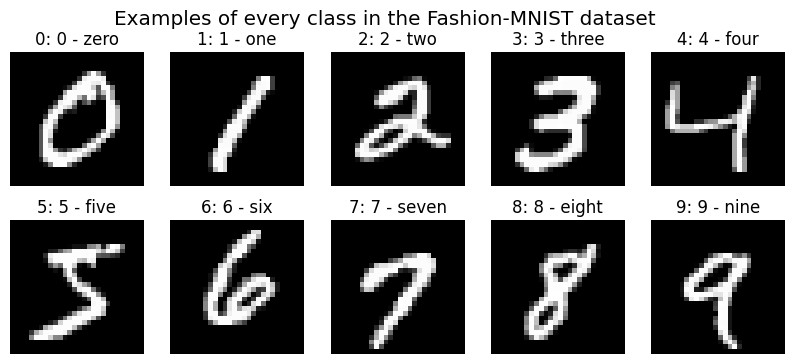

In [6]:
# 各クラスのラベルを持つサンプルを1つずつ取得する。
import matplotlib.pyplot as plt
class_ids, sample_indices = np.unique(train_set.targets, return_index=True)

fig = plt.figure(figsize=(10, 4))
fig.suptitle(
    "Examples of every class in the Fashion-MNIST dataset", fontsize="x-large"
)

for i in class_ids:
    img = train_set.data[sample_indices[i]]
    class_name = train_set.classes[i]

    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title(f"{i}: {class_name}")
    ax.set_axis_off()
    ax.imshow(img, cmap="gray")

plt.show()

データセットの数: 10000
データセットの情報: 2
type(img): <class 'torch.Tensor'>


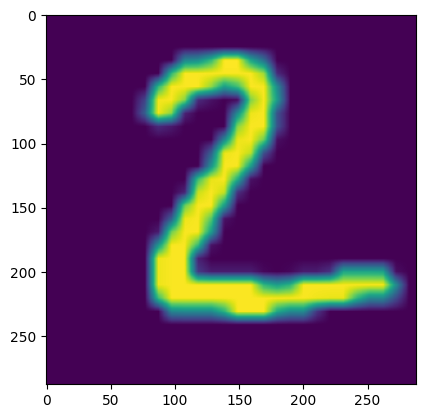

In [7]:
# データセットの確認
dataset_index=1
print("データセットの数:",len(val_set))
print("データセットの情報:", val_set[dataset_index][1])
img =  val_set[dataset_index][0]
img = torch.squeeze(img)
plt.imshow(img)
print("type(img):",type(img))
#test = MyDatasets(train_datasets,transform)

In [5]:
# # 288×288のサイズのモデル

output_class = 10
class Net_288(nn.Module):
    def __init__(self):
        super(Net_288, self).__init__()
        ##torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1)
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #MNISTのデータはグレースケールだから、channel数は1である
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout2d(0.5)
        self.dropout4 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(8192, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        ##torch.nn.functional.max_pool2d(input, kernel_size, stride=kernel_size)
        #max_pool2dのstrideのデフォルトはkernel_size
        x = F.max_pool2d(x, 2)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 4)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

class NetClf(nn.Module):
    def __init__(self):
        super(NetClf, self).__init__()
        self.fc = nn.Linear(128, output_class)

    def forward(self, x):
        x = self.fc(x)
        #return F.log_softmax(x,dim=1)
        return x

In [6]:
# # # 28×28のサイズのモデル

# output_class = 10
# class Net_288(nn.Module):
#     def __init__(self):
#         super(Net_288, self).__init__()
#         ##torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1)
#         self.conv1 = nn.Conv2d(1, 32, 3, 1) #MNISTのデータはグレースケールだから、channel数は1である
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.conv3 = nn.Conv2d(64, 128, 3, 1)
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout2d(0.25)
#         self.dropout3 = nn.Dropout2d(0.5)
#         self.fc1 = nn.Linear(15488, 128)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = self.conv3(x)
#         x = F.relu(x)
#         ##torch.nn.functional.max_pool2d(input, kernel_size, stride=kernel_size)
#         #max_pool2dのstrideのデフォルトはkernel_size
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         return x

# class NetClf(nn.Module):
#     def __init__(self):
#         super(NetClf, self).__init__()
#         self.fc = nn.Linear(128, output_class)

#     def forward(self, x):
#         x = self.fc(x)
#         #return F.log_softmax(x,dim=1)
#         return x

In [7]:
# # # 288×288のサイズのモデル

# output_class = 10

# class Net_288(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv3 = nn.Conv2d(16, 16, 5)
#         self.fc1 = nn.Linear(32768, 115)
#         self.fc2 = nn.Linear(115, 84)
#         self.fc3 = nn.Linear(84, 128)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = x.view(-1, 32768)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# class NetClf(nn.Module):
#     def __init__(self):
#         super(NetClf, self).__init__()
#         self.fc = nn.Linear(128, output_class)

#     def forward(self, x):
#         x = self.fc(x)
#         #return F.log_softmax(x,dim=1)
#         return x

In [8]:
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        # self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, input, label):
        # normalize features
        x = F.normalize(input)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W)
        # add margin
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = torch.cos(theta + self.m)
        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = logits * (1 - one_hot) + target_logits * one_hot
        # feature re-scale
        with torch.no_grad():
            B_avg = torch.where(one_hot < 1, self.s * torch.exp(logits), torch.zeros_like(logits))
            B_avg = torch.sum(B_avg) / input.size(0)
            # print(B_avg)
            theta_med = torch.median(theta)
            self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        # print(self.s)
        output *= self.s

        return output

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [11]:
def train(train_loader, model, metric_fc, criterion, optimizer, modelclf, optimizerclf):
    losses = AverageMeter()
    loss1s = AverageMeter()
    loss2s = AverageMeter()
    acc1s = AverageMeter()
    acc1cs = AverageMeter()

    # switch to train mode
    model.train()
    metric_fc.train()
    modelclf.train()

    for i, (data, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, label = data.to(device), label.to(device)

        feature = model(data)
        output = metric_fc(feature, label)
        outputc = modelclf(feature)
        loss1 = criterion(output, label)
        loss2 = criterion(outputc, label)
        loss = loss1 + loss2

        acc1, = accuracy(output, label, topk=(1,))
        acc1c, = accuracy(outputc, label, topk=(1,))

        losses.update(loss.item(), data.size(0))
        loss1s.update(loss1.item(), data.size(0))
        loss2s.update(loss2.item(), data.size(0))
        acc1s.update(acc1.item(), data.size(0))
        acc1cs.update(acc1c.item(), data.size(0))

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        optimizerclf.zero_grad()
        loss.backward()
        optimizer.step()
        optimizerclf.step()

    log = OrderedDict([
        ('loss', losses.avg),
        ('loss1',loss1s.avg),
        ('loss2',loss2s.avg),
        ('acc1', acc1s.avg),
        ('acc1c',acc1cs.avg),
    ])

    return log

In [12]:
#def validate(val_loader, model, metric_fc, criterion):
def validate(val_loader, model, metric_fc, criterion, modelclf):
    losses = AverageMeter()
    loss1s = AverageMeter()
    loss2s = AverageMeter()
    acc1s = AverageMeter()
    acc1cs = AverageMeter()

    # switch to evaluate mode
    model.eval()
    metric_fc.eval()
    modelclf.eval()

    with torch.no_grad():
        for i, (data, label) in tqdm(enumerate(val_loader), total=len(val_loader)):
            data,label = data.to(device),label.to(device)

            feature = model(data)
            output = metric_fc(feature, label)
            outputc = modelclf(feature)
            loss1 = criterion(output, label)
            loss2 = criterion(outputc, label)
            loss = loss1 + loss2
            acc1, = accuracy(output, label, topk=(1,))
            acc1c, = accuracy(outputc, label, topk=(1,))

            losses.update(loss.item(), data.size(0))
            loss1s.update(loss1.item(), data.size(0))
            loss2s.update(loss2.item(), data.size(0))
            acc1s.update(acc1.item(), data.size(0))
            acc1cs.update(acc1c.item(), data.size(0))

    log = OrderedDict([
        ('loss', losses.avg),
        ('loss1',loss1s.avg),
        ('loss2',loss2s.avg),
        ('acc1', acc1s.avg),
        ('acc1c',acc1cs.avg),
    ])

    return log

In [14]:
epochs=50

# class分類数をデータセットに合わせる
# embedding用モデル
model = Net_288().to(device)
num_features = model.fc1.out_features
metric_fc = AdaCos(num_features, num_classes=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.02)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

# embeddings→16クラス分類モデル
modelclf = NetClf().to(device)
optimizerclf = optim.SGD(modelclf.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

In [15]:
summary(model=model,input_size=(1, 288, 288))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 286, 286]             320
            Conv2d-2         [-1, 64, 141, 141]          18,496
            Conv2d-3          [-1, 128, 68, 68]          73,856
            Conv2d-4          [-1, 128, 32, 32]         147,584
         Dropout2d-5            [-1, 128, 8, 8]               0
            Linear-6                  [-1, 128]       1,048,704
Total params: 1,288,960
Trainable params: 1,288,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.32
Forward/backward pass size (MB): 35.26
Params size (MB): 4.92
Estimated Total Size (MB): 40.49
----------------------------------------------------------------


In [16]:
log = pd.DataFrame(index=[],
                   columns=[ 'epoch', 'lr', 'loss', 'loss1','loss2','acc1','acc1c'
                            , 'val_loss', 'val_loss1','val_loss2','val_acc1','val_acc1c'])
best_loss = float('inf')

for epoch in range(epochs):
    print('Epoch [%d/%d]' %(epoch+1, epochs))

    scheduler.step()

    # train for one epoch
    train_log = train(train_loader, model, metric_fc, criterion, optimizer, modelclf, optimizerclf)
    # evaluate on validation set
    val_log = validate(validation_dataloader, model, metric_fc, criterion, modelclf)
    print('loss %f - acc1 %f - val_loss %f - val_acc %f'
            %(train_log['loss'], train_log['acc1'], val_log['loss'], val_log['acc1']))

    tmp = pd.Series([
            epoch,
            scheduler.get_lr()[0],
            train_log['loss'],
            train_log['loss1'],
            train_log['loss2'],
            train_log['acc1'],
            train_log['acc1c'],
            val_log['loss'],
            val_log['loss1'],
            val_log['loss2'],
            val_log['acc1'],
            val_log['acc1c'],
        ], index=['epoch', 'lr', 'loss','loss1','loss2','acc1','acc1c'
                  ,'val_loss','val_loss1','val_loss2', 'val_acc1','val_acc1c'])

    log = log.append(tmp, ignore_index=True)
    log.to_csv('./models_log.csv', index=False)

    if val_log['loss'] < best_loss:
        torch.save({
            'model':model.state_dict(),
            'metric_fc':metric_fc.state_dict(),
            'optimizer':optimizer.state_dict(),
            'modelclf':modelclf.state_dict(),
            'optimizerclf':optimizerclf.state_dict(),
        },'./model.pt')
        best_loss = val_log['loss']
        print("=> saved best model")

Epoch [1/50]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for

loss 3.572769 - acc1 68.110000 - val_loss 2.896586 - val_acc 85.910000
=> saved best model
Epoch [2/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 1.579002 - acc1 82.381667 - val_loss 0.705918 - val_acc 86.560000
=> saved best model
Epoch [3/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.752104 - acc1 86.043333 - val_loss 0.630200 - val_acc 88.340000
=> saved best model
Epoch [4/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.676894 - acc1 87.556667 - val_loss 0.573766 - val_acc 89.520000
=> saved best model
Epoch [5/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.631875 - acc1 88.560000 - val_loss 0.538618 - val_acc 90.140000
=> saved best model
Epoch [6/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.600241 - acc1 89.305000 - val_loss 0.531420 - val_acc 90.590000
=> saved best model
Epoch [7/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.573817 - acc1 89.770000 - val_loss 0.510607 - val_acc 91.060000
=> saved best model
Epoch [8/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.555590 - acc1 90.233333 - val_loss 0.488233 - val_acc 91.530000
=> saved best model
Epoch [9/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.538098 - acc1 90.651667 - val_loss 0.478235 - val_acc 91.880000
=> saved best model
Epoch [10/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.523410 - acc1 90.886667 - val_loss 0.484924 - val_acc 91.500000
Epoch [11/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.511381 - acc1 91.103333 - val_loss 0.459015 - val_acc 92.140000
=> saved best model
Epoch [12/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.499292 - acc1 91.456667 - val_loss 0.450622 - val_acc 92.470000
=> saved best model
Epoch [13/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.487603 - acc1 91.726667 - val_loss 0.445037 - val_acc 92.560000
=> saved best model
Epoch [14/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.479313 - acc1 91.985000 - val_loss 0.440219 - val_acc 92.730000
=> saved best model
Epoch [15/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.472634 - acc1 91.996667 - val_loss 0.428991 - val_acc 92.890000
=> saved best model
Epoch [16/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.464254 - acc1 92.246667 - val_loss 0.424930 - val_acc 93.030000
=> saved best model
Epoch [17/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.457270 - acc1 92.406667 - val_loss 0.418764 - val_acc 93.050000
=> saved best model
Epoch [18/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.452291 - acc1 92.420000 - val_loss 0.417578 - val_acc 92.940000
=> saved best model
Epoch [19/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.444237 - acc1 92.643333 - val_loss 0.410931 - val_acc 93.120000
=> saved best model
Epoch [20/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.437026 - acc1 92.788333 - val_loss 0.403627 - val_acc 93.260000
=> saved best model
Epoch [21/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.431086 - acc1 92.893333 - val_loss 0.403336 - val_acc 93.620000
=> saved best model
Epoch [22/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.426875 - acc1 92.991667 - val_loss 0.395259 - val_acc 93.520000
=> saved best model
Epoch [23/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.421078 - acc1 93.151667 - val_loss 0.396826 - val_acc 93.370000
Epoch [24/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.417030 - acc1 93.243333 - val_loss 0.390558 - val_acc 93.560000
=> saved best model
Epoch [25/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.411091 - acc1 93.301667 - val_loss 0.395044 - val_acc 93.430000
Epoch [26/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.407140 - acc1 93.420000 - val_loss 0.382218 - val_acc 93.860000
=> saved best model
Epoch [27/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.403288 - acc1 93.556667 - val_loss 0.384444 - val_acc 93.860000
Epoch [28/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.400483 - acc1 93.558333 - val_loss 0.379181 - val_acc 93.870000
=> saved best model
Epoch [29/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.395274 - acc1 93.661667 - val_loss 0.371984 - val_acc 94.200000
=> saved best model
Epoch [30/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.393310 - acc1 93.640000 - val_loss 0.386513 - val_acc 93.820000
Epoch [31/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.387896 - acc1 93.835000 - val_loss 0.373484 - val_acc 94.090000
Epoch [32/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.385436 - acc1 93.903333 - val_loss 0.369835 - val_acc 94.310000
=> saved best model
Epoch [33/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.380829 - acc1 94.045000 - val_loss 0.367996 - val_acc 94.150000
=> saved best model
Epoch [34/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.377512 - acc1 94.093333 - val_loss 0.366196 - val_acc 94.260000
=> saved best model
Epoch [35/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.376387 - acc1 94.095000 - val_loss 0.361289 - val_acc 94.260000
=> saved best model
Epoch [36/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.371425 - acc1 94.248333 - val_loss 0.356924 - val_acc 94.380000
=> saved best model
Epoch [37/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.369210 - acc1 94.201667 - val_loss 0.354403 - val_acc 94.430000
=> saved best model
Epoch [38/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.364636 - acc1 94.425000 - val_loss 0.356613 - val_acc 94.460000
Epoch [39/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.364858 - acc1 94.425000 - val_loss 0.353770 - val_acc 94.580000
=> saved best model
Epoch [40/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.359924 - acc1 94.448333 - val_loss 0.348779 - val_acc 94.630000
=> saved best model
Epoch [41/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.359245 - acc1 94.518333 - val_loss 0.347251 - val_acc 94.640000
=> saved best model
Epoch [42/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.356834 - acc1 94.540000 - val_loss 0.342250 - val_acc 94.780000
=> saved best model
Epoch [43/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.352961 - acc1 94.651667 - val_loss 0.344153 - val_acc 94.710000
Epoch [44/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.349313 - acc1 94.668333 - val_loss 0.343327 - val_acc 94.670000
Epoch [45/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.348778 - acc1 94.731667 - val_loss 0.340312 - val_acc 94.730000
=> saved best model
Epoch [46/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.347981 - acc1 94.736667 - val_loss 0.342045 - val_acc 94.790000
Epoch [47/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.342859 - acc1 94.771667 - val_loss 0.341568 - val_acc 94.710000
Epoch [48/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.341455 - acc1 94.886667 - val_loss 0.341642 - val_acc 94.730000
Epoch [49/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.339576 - acc1 94.911667 - val_loss 0.334989 - val_acc 94.860000
=> saved best model
Epoch [50/50]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still u

loss 0.336340 - acc1 94.966667 - val_loss 0.334362 - val_acc 94.930000
=> saved best model



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
<ipython-input-16-d9507dd288a5>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(tmp, ignore_index=True)


In [17]:
# 保存したモデル・オプティマイザーがロードできるか確認
model_load = Net_288().to(device)
num_features_load = model_load.fc1.out_features
metric_fc_load = AdaCos(num_features, num_classes=output_class).to(device)
optimizer_load = optim.SGD(model_load.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
modelclf_load = NetClf().to(device)
optimizerclf_load = optim.SGD(modelclf_load.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

checkpoint = torch.load('./model.pt')
model_load.load_state_dict(checkpoint['model'])
metric_fc_load.load_state_dict(checkpoint['metric_fc'])
optimizer_load.load_state_dict(checkpoint['optimizer'])
modelclf_load.load_state_dict(checkpoint['modelclf'])
optimizerclf_load.load_state_dict(checkpoint['optimizerclf'])

Text(0.5, 1.0, 'loss')

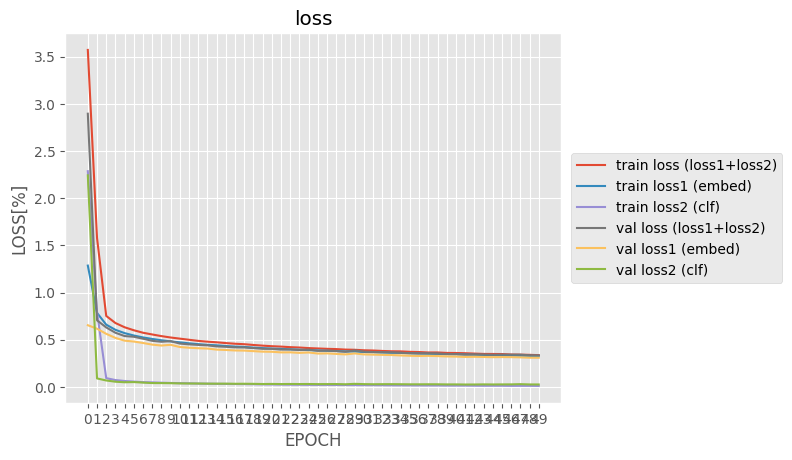

In [18]:
da=pd.read_csv('./models_log.csv')
plt.style.use('ggplot')
plt.plot(da["epoch"],da["loss"], label='train loss (loss1+loss2)')
plt.plot(da["epoch"],da["loss1"], label='train loss1 (embed)')
plt.plot(da["epoch"],da["loss2"], label='train loss2 (clf)')
plt.plot(da["epoch"],da["val_loss"], label='val loss (loss1+loss2)')
plt.plot(da["epoch"],da["val_loss1"], label='val loss1 (embed)')
plt.plot(da["epoch"],da["val_loss2"], label='val loss2 (clf)')
plt.legend(loc="center left",bbox_to_anchor=(1.02,0.5,), borderaxespad=0)
plt.xticks(np.arange(0, len(da["epoch"]), step=1))
plt.xlabel('EPOCH')
plt.ylabel('LOSS[%]')
plt.title('loss')
#plt.grid()

Text(0.5, 1.0, 'accuracy')

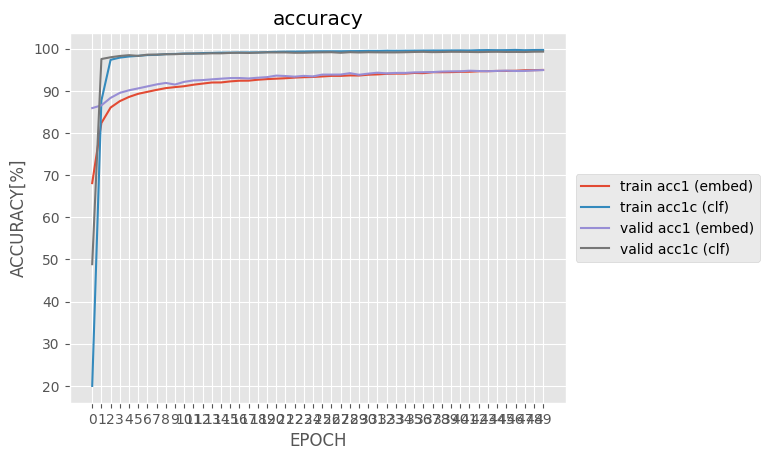

In [19]:
plt.style.use('ggplot')
plt.plot(da["acc1"], label='train acc1 (embed)')
plt.plot(da["acc1c"], label='train acc1c (clf)')
plt.plot(da["val_acc1"], label='valid acc1 (embed)')
plt.plot(da["val_acc1c"], label='valid acc1c (clf)')
plt.xticks(np.arange(0, len(da["epoch"]), step=1))
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY[%]')
#plt.legend(['train acc', 'val acc'])
plt.legend(loc="center left",bbox_to_anchor=(1.02,0.5,), borderaxespad=0)
plt.title('accuracy')

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

results = np.zeros((1,128))
for img, label in tqdm(train_loader):
    img, label = img.to(device), label.to(device)
    pred = model(img)
    #print(pred.shape)
    pred_num = pred.to("cpu").detach().numpy().copy()
    print(results.shape)
    results = np.concatenate([results, pred_num])

print(results.shape)
results[0,:]

results_del = np.delete(results, 0, 0)
print(results_del)
print(results_del.shape)

clf = LocalOutlierFactor(n_neighbors=22, novelty=True, contamination=0.0001)
clf.fit(results_del)

In [ ]:
#MNIST testで実施

val_results = np.zeros((1,128))
for img, label in tqdm(validation_dataloader):
    img, label = img.to(device), label.to(device)
    pred = model(img)
    #print(pred.shape)
    pred_num = pred.to("cpu").detach().numpy().copy()
    print(val_results.shape)
    val_results = np.concatenate([val_results, pred_num])

val_results_del = np.delete(val_results, 0, 0)
print(val_results_del)
print(val_results_del.shape)

y_pred_test = clf.predict(val_results_del)
n_error_test = y_pred_test[y_pred_test == -1].size
print(n_error_test)

In [ ]:
fashion_train_dataset = datasets.FashionMNIST(
    root="datasets", train=True, transform=transform, download=True
)
fashion_train_data_loader = torch.utils.data.DataLoader(
    fashion_train_dataset, batch_size=64, shuffle=True
)

In [ ]:
val_fashion_results = np.zeros((1,128))
for img, label in tqdm(fashion_train_data_loader):
    img, label = img.to(device), label.to(device)
    pred = model(img)
    #print(pred.shape)
    pred_num = pred.to("cpu").detach().numpy().copy()
    print(val_results.shape)
    val_fashion_results = np.concatenate([val_fashion_results, pred_num])

val_fashion_results_del = np.delete(val_fashion_results, 0, 0)
print(val_fashion_results_del)
print(val_fashion_results_del.shape)

y_pred_test = clf.predict(val_fashion_results_del)
n_error_test = y_pred_test[y_pred_test == -1].size
print(n_error_test)

In [ ]:
y_pred_test
val_concat_label = np.empty(0)
for i, data in enumerate(val_loader):
        x, y = data
        y_numpy = y.to("cpu").detach().numpy().copy()
        val_concat_label = np.concatenate( [val_concat_label,y_numpy])
        #print(y_numpy)
val_concat_label = val_concat_label

In [ ]:
import collections
print(y_pred_test==-1)
#print("val_concat_label",val_concat_label[y_pred_test==-1])
error_label = val_concat_label[y_pred_test==-1]
print("error_label",error_label)
error_label_count = collections.Counter(error_label)
print("error_label_count",error_label_count)
print(error_label_count[1])

## **validation setのそれぞれの画像枚数を数える**

In [ ]:
import collections
val_dataset_label_list = []
for dataset_index in range(len(val_set)):
  val_dataset_label_list.append( val_set[dataset_index][1] )
val_dataset_label_count = collections.Counter(val_dataset_label_list)
print(val_dataset_label_count)

In [ ]:
result_error_dict = {}
for key in val_dataset_label_count.keys():
  if key in error_label_count:
    error_rate = (error_label_count[key]/val_dataset_label_count[key]) * 100
    result_error_dict[str(key)] = error_rate
    #result_error_dict.setdefault(str(key),error_rate)
  else:
    error_rate = 0 * 100
    result_error_dict[str(key)] = error_rate
    #result_error_dict.setdefault(str(key),error_rate)
result_error_dict = sorted(result_error_dict.items())
result_error_dict = dict((x, y) for x, y in result_error_dict)
print(result_error_dict)

for kk, vv in result_error_dict.items():
    print("key:",kk,"Error rate:",vv)


In [ ]:
for i, (label_name, judge_val) in enumerate(zip(val_concat_label, y_pred_test)):
  if judge_val == -1:
    print("data index",i)
    print("val_concat_label",[val_concat_label[i]])

In [ ]:
val_concat_label

In [ ]:
from torchsummary import summary
summary(model, [( 1, 28, 28)])

In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
def get_mnist_loader(is_train: bool, batch_size: int) -> DataLoader:
    trainset = datasets.FashionMNIST(
                                root="./data",
                                train=is_train,
                                transform=ToTensor(),
                                download=True
                              )
    return DataLoader(trainset, batch_size=batch_size, shuffle=is_train)

# data loder
train_fashion_loader = get_mnist_loader(is_train=True, batch_size=64)

In [ ]:
#Fashion }MNIST testで実施

val_results = np.zeros((1,100))
for img, label in tqdm(train_fashion_loader):
    img, label = img.to(device), label.to(device)
    pred = model(img)
    #print(pred.shape)
    pred_num = pred.to("cpu").detach().numpy().copy()
    print(val_results.shape)
    val_results = np.concatenate([val_results, pred_num])

val_results_del = np.delete(val_results, 0, 0)
print(val_results_del)
print(val_results_del.shape)

y_pred_test = clf.predict(val_results_del)
n_error_test = y_pred_test[y_pred_test == -1].size
print(n_error_test)